#Imports & Data Fcns

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.measure
import random
import torch
import torch.nn as nn
from torch.optim import Adam
from torchmetrics import Accuracy
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader, random_split
from pytorch_lightning.callbacks import ModelCheckpoint, StochasticWeightAveraging
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.tuner import Tuner
import pytorch_lightning as pl

%load_ext autoreload
%autoreload 2

In [2]:
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

def prepare_synth_dataset_augment(g, classIX, X=None, y=None, percent_used=1):
  X_test = np.load("project/X_test.npy")
  y_test = np.load("project/y_test.npy")
  person_test = np.load("project/person_test.npy")
  person_train_valid = np.load("project/person_train_valid.npy")
  X_train_valid = np.load("project/X_train_valid.npy")
  y_train_valid = np.load("project/y_train_valid.npy")

  ind_valid = np.random.choice(2115, 100, replace=False)
  ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))
  X_train = X_train_valid[ind_train]
  X_valid = X_train_valid[ind_valid]
  y_train = y_train_valid[ind_train]
  y_valid = y_train_valid[ind_valid]
  person_train = person_train_valid[ind_train]
  person_valid = person_train_valid[ind_valid]

  if not classIX is None:
    train_ind = np.where(y_valid-769==classIX)
    valid_ind = np.where(y_valid-769==classIX)
    test_ind = np.where(y_test-769==classIX)

    X_test = X_test[test_ind]
    y_test = y_test[test_ind]
    person_test = person_test[test_ind]

    person_valid = person_valid[valid_ind]
    X_valid = X_valid[valid_ind]
    y_valid = y_valid[valid_ind]

    person_train = person_train[train_ind]
    X_train = X_train[train_ind]
    y_train = y_train[train_ind]

  train_b = y_train.shape[0]
  y_train_onehot = np.zeros((train_b, 4))
  for IX in range(len(y_train)):
    class_IX = int(y_train[IX] - 769)
    y_train_onehot[IX, class_IX] = 1

  test_b = y_test.shape[0]
  y_test_onehot = np.zeros((test_b, 4))
  for IX in range(len(y_test)):
    class_IX = int(y_test[IX] - 769)
    y_test_onehot[IX, class_IX] = 1

  valid_b = y_valid.shape[0]
  y_valid_onehot = np.zeros((valid_b, 4))
  for IX in range(len(y_valid)):
    class_IX = int(y_valid[IX] - 769)
    y_valid_onehot[IX, class_IX] = 1

  person_train_onehot = np.zeros((train_b, 9))
  for IX in range(len(person_train)):
    class_IX = int(person_train[IX])
    person_train_onehot[IX, class_IX] = 1

  person_test_onehot = np.zeros((test_b, 9))
  for IX in range(len(person_test)):
    class_IX = int(person_test[IX])
    person_test_onehot[IX, class_IX] = 1

  person_valid_onehot = np.zeros((valid_b, 9))
  for IX in range(len(person_valid)):
    class_IX = int(person_valid[IX])
    person_valid_onehot[IX, class_IX] = 1

  X_test_tensor = torch.Tensor(X_test)
  y_test_tensor = torch.Tensor(y_test_onehot)
  person_test_tensor = torch.Tensor(person_test_onehot)
  person_valid_tensor = torch.Tensor(person_valid_onehot)
  X_valid_tensor = torch.Tensor(X_valid)
  y_valid_tensor = torch.Tensor(y_valid_onehot)
  person_train_tensor = torch.Tensor(person_train_onehot)
  X_train_tensor = torch.Tensor(X_train)
  y_train_tensor = torch.Tensor(y_train_onehot)

  train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
  valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
  test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
  train_trials = X_train.shape[0]
  valid_trials = X_valid.shape[0]

  train_dataloader = DataLoader(train_dataset, batch_size=train_trials, pin_memory=True, worker_init_fn=seed_worker, generator=g)
  valid_dataloader = DataLoader(valid_dataset, batch_size=valid_trials, pin_memory=True, worker_init_fn=seed_worker, generator=g)
  test_dataloader = DataLoader(test_dataset, worker_init_fn=seed_worker, generator=g)

  return train_dataloader, valid_dataloader, test_dataloader

In [3]:
def augment(X, y, subject, subsample_size, average_size):
  X_total = None
  y_total = None
  subject_total = None
  # Maxpool
  X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, subsample_size), axis=3)
  X_total = X_max
  y_total = y
  subject_total = subject
  # Average
  X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average_size), axis=3)
  X_average += np.random.normal(0, 0.2, X_average.shape)
  X_total = np.vstack((X_total, X_average))
  y_total = np.vstack((y_total, y))
  subject_total = np.vstack((subject_total, subject))
  # Minpool
  X_min = np.min(X.reshape(X.shape[0], X.shape[1], -1, average_size), axis=3)
  X_average += np.random.normal(0, 0.25, X_average.shape)
  X_total = np.vstack((X_total, X_min))
  y_total = np.vstack((y_total, y))
  subject_total = np.vstack((subject_total, subject))
  # 1.2 Scale
  X_min = 1.2 * np.max(X.reshape(X.shape[0], X.shape[1], -1, average_size), axis=3)
  X_total = np.vstack((X_total, X_min))
  y_total = np.vstack((y_total, y))
  subject_total = np.vstack((subject_total, subject))
  # 0.8 Scale
  X_min = 0.8 * np.max(X.reshape(X.shape[0], X.shape[1], -1, average_size), axis=3)
  X_total = np.vstack((X_total, X_min))
  y_total = np.vstack((y_total, y))
  subject_total = np.vstack((subject_total, subject))
  # Subsampling
  for i in range(subsample_size):
    X_subsample = X[:,:,i::subsample_size] + np.random.normal(0, 0.5, X[:,:,i::subsample_size].shape)
    X_total = np.vstack((X_total, X_subsample))
    y_total = np.vstack((y_total, y))
    subject_total = np.vstack((subject_total, subject))
  return X_total, y_total, subject_total

def prepare_dataset_augment(g, classIX):
  X_test = np.load("project/X_test.npy")
  y_test = np.load("project/y_test.npy")
  person_test = np.load("project/person_test.npy")
  person_train_valid = np.load("project/person_train_valid.npy")
  X_train_valid = np.load("project/X_train_valid.npy")
  y_train_valid = np.load("project/y_train_valid.npy")
    
  if not classIX is None:
    train_ind = np.where(y_train_valid-769==classIX)
    test_ind = np.where(y_test-769==classIX)
    
    X_test = X_test[test_ind]
    y_test = y_test[test_ind]
    person_test = person_test[test_ind]
    person_train_valid = person_train_valid[train_ind]
    X_train_valid = X_train_valid[train_ind]
    y_train_valid = y_train_valid[train_ind]

  train_b = y_train_valid.shape[0]
  y_train_onehot = np.zeros((train_b, 4))
  for IX in range(len(y_train_valid)):
    class_IX = int(y_train_valid[IX] - 769)
    y_train_onehot[IX, class_IX] = 1

  test_b = y_test.shape[0]
  y_test_onehot = np.zeros((test_b, 4))
  for IX in range(len(y_test)):
    class_IX = int(y_test[IX] - 769)
    y_test_onehot[IX, class_IX] = 1

  person_train_onehot = np.zeros((train_b, 9))
  for IX in range(len(person_train_valid)):
    class_IX = int(person_train_valid[IX])
    person_train_onehot[IX, class_IX] = 1

  person_test_onehot = np.zeros((test_b, 9))
  for IX in range(len(person_test)):
    class_IX = int(person_test[IX])
    person_test_onehot[IX, class_IX] = 1

  # Augmentations
  X_train_valid = X_train_valid[:,:,0:512]
  X_test = X_test[:,:,0:512]
  X_train_valid, y_train_onehot, person_train_onehot = augment(X_train_valid, y_train_onehot, person_train_onehot, 2, 2)
  X_test, y_test_onehot, person_test_onehot = augment(X_test, y_test_onehot, person_test_onehot, 2, 2)

  X_test_tensor = torch.Tensor(X_test)
  y_test_tensor = torch.Tensor(y_test_onehot)
  person_test_tensor = torch.Tensor(person_test_onehot)
  person_train_valid_tensor = torch.Tensor(person_train_onehot)
  X_train_valid_tensor = torch.Tensor(X_train_valid)
  y_train_valid_tensor = torch.Tensor(y_train_onehot)

  full_train_dataset = TensorDataset(X_train_valid_tensor, y_train_valid_tensor, person_train_valid_tensor)
  test_dataset = TensorDataset(X_test_tensor, y_test_tensor, person_test_tensor)
  trials = X_train_valid.shape[0]
  train_dataset, validation_dataset = random_split(full_train_dataset, [0.8,0.2])

  train_dataloader = DataLoader(train_dataset, batch_size=512, pin_memory=True, worker_init_fn=seed_worker, generator=g)
  validation_dataloader = DataLoader(validation_dataset, batch_size=512, pin_memory=True, worker_init_fn=seed_worker, generator=g)
  test_dataloader = DataLoader(test_dataset, worker_init_fn=seed_worker, generator=g)

  return train_dataloader, validation_dataloader, test_dataloader

#TRAIN "VAE"

In [4]:
torch.use_deterministic_algorithms(True, warn_only=True)

checkpoint_callback = ModelCheckpoint(
    save_top_k=3,
    monitor="val_loss",
    mode="min",
    dirpath=None,
    filename="best_val-{epoch:02d}-{val_loss:.2f}",
)

def test(model_name, desc, seed):
  pl.seed_everything(seed, workers=True)
  g = torch.Generator()
  g.manual_seed(seed)
  train_dataloader, validation_dataloader, test_dataloader = prepare_dataset(g)
  logger = pl.loggers.TensorBoardLogger('Blake_Vae_logs', name=model_name+desc+",no_augment")
  model = model_dict[model_name]
  early_stopping_callback = EarlyStopping(monitor='val_loss', mode='min', patience=12)
  trainer = pl.Trainer(max_epochs=500, logger=logger, 
                       callbacks=[early_stopping_callback, checkpoint_callback, StochasticWeightAveraging(swa_lrs=1e-2)], 
                       accelerator="gpu", devices=1, deterministic=True, 
                       gradient_clip_val=0.75, log_every_n_steps=4, accumulate_grad_batches=8
                      
                      )
  trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=validation_dataloader)
  return trainer, model, test_dataloader

def test_augment(model_name, desc, seed, classIX=None):
  pl.seed_everything(seed, workers=True)
  g = torch.Generator()
  g.manual_seed(seed)
  train_dataloader, validation_dataloader, test_dataloader = prepare_dataset_augment(g, classIX)
  logger = pl.loggers.TensorBoardLogger('Vae_logs', name=model_name+desc+",augment")
  model = model_dict[model_name]
  early_stopping_callback = EarlyStopping(monitor='val_loss', mode='min', patience=8)
  trainer = pl.Trainer(max_epochs=500, logger=logger, 
                       callbacks=[early_stopping_callback, checkpoint_callback, StochasticWeightAveraging(swa_lrs=3e-4, swa_epoch_start=60)], 
                       accelerator="gpu", devices=1, deterministic=True,
                       gradient_clip_val=0.75, log_every_n_steps=4, accumulate_grad_batches=13)
  trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=validation_dataloader)
  return trainer, model, test_dataloader

In [7]:
from models.Diffusion import *

#@title Get Model
learning_rate = 3e-4 #@param {type:"number"}
hidden = 192
us = (1,2,4,8)
timesteps = 50
noise = [2e-2,2e-1]



model_dict = {"EEG Diffusion_B": EEGDiffusion(hidden, learning_rate, us=us, timesteps=timesteps, noise=noise),
              "EEG Diffusion_H": EEGDiffusion_Hybrid(hidden, learning_rate, us=us, timesteps=timesteps, noise=noise)}
model_name = "EEG Diffusion_H"
augment_form = True #@param {type:"boolean"}
desc = str(hidden)+"hidden," + str(timesteps) + ",lr" + str(learning_rate) + "," + str(us) + "," +str(noise) #@param {type:"string"}

tester = None
if augment_form:
  tester = test_augment
else:
  tester = test



In [9]:
Dtrainer, Dmodel, Dtest_dataloader = tester(model_name, desc, 42)

Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: Vae_logs\EEG Diffusion_H192hidden,50,lr0.0003,(1, 2, 4, 8),[0.02, 0.2],augment
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\17076\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\core\optimizer.py:251: RuntimeWarning: Found unsupported keys in the lr scheduler dict: {'optimizer'}. HINT: remove them from the output of `configure_optimizers`.
  rank_zero_warn(

  | Name  | Type        | Params
--------

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\17076\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\17076\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

C:\Users\17076\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:04<00:00,  7.31it/s]


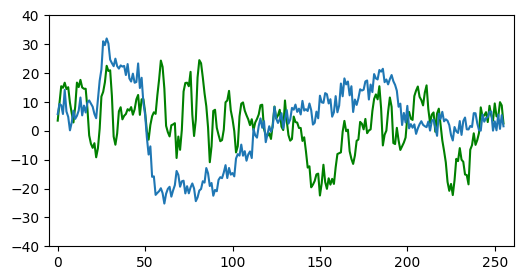

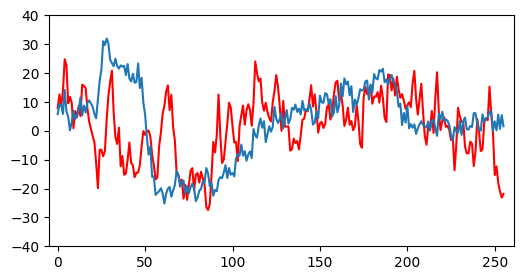

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:04<00:00,  7.22it/s]


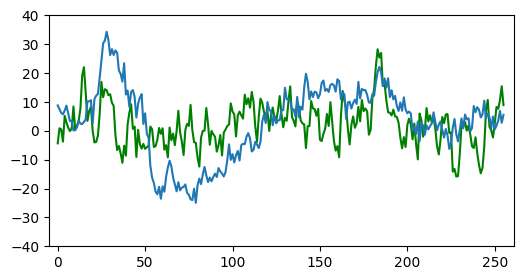

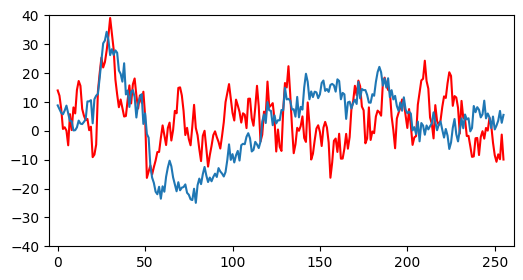

In [ ]:
X_train_valid = np.load("project/X_train_valid.npy")
y_train_valid = np.load("project/y_train_valid.npy")
sl = 256
channel = 8

for class_IX in range(2):
    ch_data = X_train_valid[:,channel,:]
    class_0_ind=np.where(y_train_valid-769==class_IX)
    ch_data = ch_data[class_0_ind]
    avg_ch_data_class_0 = np.mean(ch_data, axis=0)[:512]
    avg_ch_data_class_0 = skimage.measure.block_reduce(avg_ch_data_class_0, (2), np.max)
    ch_dataa = ch_data[10, :512]
    ch_dataa = skimage.measure.block_reduce(ch_dataa, (2), np.max)
    plt.figure(figsize=(6,3))
    plt.plot(np.arange(sl), ch_dataa, 'g')

    temp = np.zeros((4,))
    temp[class_IX] = 1.
    class_0 = torch.Tensor(temp)
    class_0 = class_0[None, :]
    samples = Dmodel.sampling(class_0, batch_size=1, channels=22, 
                              sequence_length=sl, initialize=torch.Tensor(avg_ch_data_class_0),
                              timesteps=36)
    synth = np.array(samples)[-1,0,channel,:]
    #synth = skimage.measure.block_reduce(synth, (8,), np.average)
    #synth = np.repeat(synth, 8, 0)
    plt.plot(np.arange(sl), synth)
    plt.xlim([-5,sl+5])
    plt.ylim([-40,40])
    plt.show()
    
    ch_data = ch_data[11, :512]
    ch_data = skimage.measure.block_reduce(ch_data, (2), np.max)
    plt.figure(figsize=(6,3))
    plt.plot(np.arange(sl), ch_data, 'r')
    plt.plot(np.arange(sl), synth)
    plt.xlim([-5,sl+5])
    plt.ylim([-40,40])
    plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.23it/s]


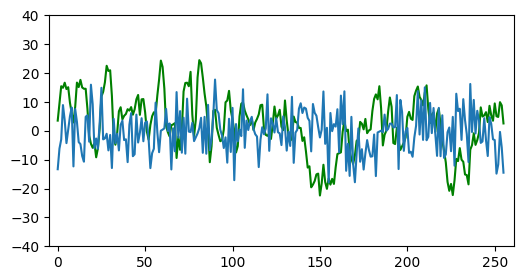

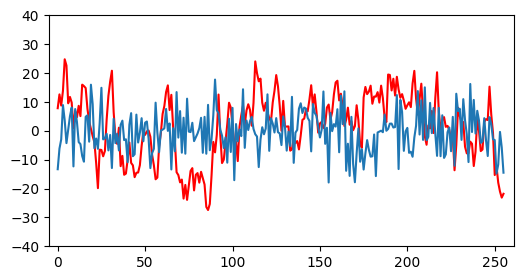

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.19it/s]


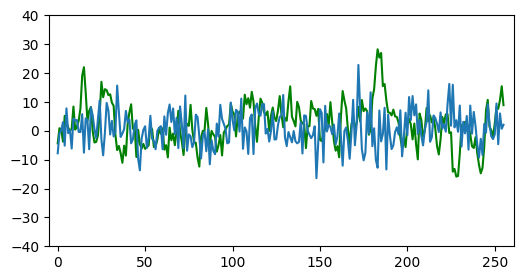

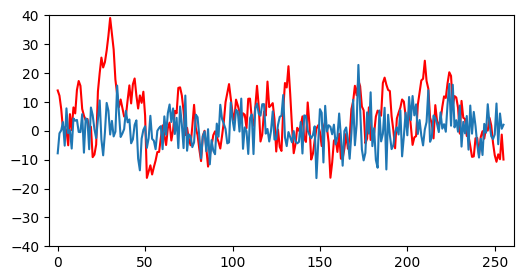

In [ ]:
X_train_valid = np.load("project/X_train_valid.npy")
y_train_valid = np.load("project/y_train_valid.npy")
sl = 256
channel = 8

for class_IX in range(2):
    ch_data = X_train_valid[:,channel,:]
    class_0_ind=np.where(y_train_valid-769==class_IX)
    ch_data = ch_data[class_0_ind]
    avg_ch_data_class_0 = np.mean(ch_data, axis=0)[:512]
    avg_ch_data_class_0 = skimage.measure.block_reduce(avg_ch_data_class_0, (2), np.max)
    ch_dataa = ch_data[10, :512]
    ch_dataa = skimage.measure.block_reduce(ch_dataa, (2), np.max)
    plt.figure(figsize=(6,3))
    plt.plot(np.arange(sl), ch_dataa, 'g')

    temp = np.zeros((4,))
    temp[class_IX] = 1.
    class_0 = torch.Tensor(temp)
    class_0 = class_0[None, :]
    samples = Dmodel.sampling(class_0, batch_size=1, channels=22, 
                              sequence_length=sl, timesteps=50)
    synth = np.array(samples)[-1,0,channel,:]
    #synth = skimage.measure.block_reduce(synth, (8,), np.average)
    #synth = np.repeat(synth, 8, 0)
    plt.plot(np.arange(sl), synth)
    plt.xlim([-5,sl+5])
    plt.ylim([-40,40])
    plt.show()
    
    ch_data = ch_data[11, :512]
    ch_data = skimage.measure.block_reduce(ch_data, (2), np.max)
    plt.figure(figsize=(6,3))
    plt.plot(np.arange(sl), ch_data, 'r')
    plt.plot(np.arange(sl), synth)
    plt.xlim([-5,sl+5])
    plt.ylim([-40,40])
    plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


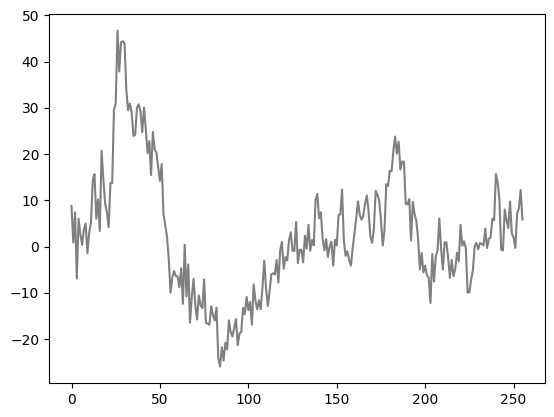

In [ ]:
import matplotlib.animation as animation
fig = plt.figure()
ims = []
for i in range(400):
    synth = np.array(samples)[i,0,channel,:]
    im = plt.plot(synth,color='gray', animated=True)
    ims.append(im)

animate = animation.ArtistAnimation(fig, ims, interval=25, blit=True, repeat_delay=1000)
animate.save('diffusion_hybrid_one_class_fft_initialized.gif')
plt.show()

In [ ]:
# batch_size=256
# sl = 256
# class_0 = torch.Tensor([1.,0.,0.,0.])
# class_0 = class_0[None, :].repeat_interleave(batch_size, dim=0)
# samples_0 = Dmodel.sampling(class_0, batch_size=batch_size, channels=22, sequence_length=sl)[-1]

# class_1 = torch.Tensor([0.,1.,0.,0.])
# class_1 = class_1[None, :].repeat_interleave(batch_size, dim=0)
# samples_1 = Dmodel.sampling(class_1, batch_size=batch_size, channels=22, sequence_length=sl)[-1]

# class_2 = torch.Tensor([0.,0.,1.,0.])
# class_2 = class_2[None, :].repeat_interleave(batch_size, dim=0)
# samples_2 = Dmodel.sampling(class_2, batch_size=batch_size, channels=22, sequence_length=sl)[-1]

# class_3 = torch.Tensor([0.,0.,0.,1.])
# class_3 = class_3[None, :].repeat_interleave(batch_size, dim=0)
# samples_3 = Dmodel.sampling(class_3, batch_size=batch_size, channels=22, sequence_length=sl)[-1]

# Initialize class average
X_train_valid = np.load("project/X_train_valid.npy")
y_train_valid = np.load("project/y_train_valid.npy")
batch_size=256
sl = 256
timesteps=38
repeats = 8

X_synth = torch.empty((0, 22, 256))
y_synth = torch.empty((0, 4))

for repeatIX in range(repeats):
    print("Repeat Number " + str(repeatIX))
    for class_IX in range(0,4):
        class_ind = np.where(y_train_valid-769==class_IX)
        class_data = X_train_valid[class_ind]
        avg_class_data = np.mean(class_data, axis=0)[:,:512]
        avg_class_data = skimage.measure.block_reduce(avg_class_data, (1,2), np.average)
        avg_class_data = torch.Tensor(avg_class_data)
        avg_class_data = avg_class_data[None,:,:].repeat_interleave(batch_size, dim=0)
        class_y = np.zeros((4,))
        class_y[class_IX] = 1.
        class_y = torch.Tensor(class_y)
        class_y = class_y[None, :].repeat_interleave(batch_size, dim=0)
        samples_X = Dmodel.sampling(class_y, batch_size=batch_size, channels=22, sequence_length=sl,
                                    initialize=avg_class_data, timesteps=timesteps)[-1]
        X_synth = torch.cat((X_synth, torch.Tensor(samples_X)))
        y_synth = torch.cat((y_synth, torch.Tensor(class_y)))
    print()
        
print(X_synth.shape)
print(y_synth.shape)

Repeat Number 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [03:30<00:00,  5.53s/it]



Repeat Number 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [03:30<00:00,  5.54s/it]



Repeat Number 2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [03:29<00:00,  5.51s/it]



Repeat Number 3


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [03:25<00:00,  5.40s/it]



Repeat Number 4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [03:22<00:00,  5.33s/it]



Repeat Number 5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [03:29<00:00,  5.50s/it]



Repeat Number 6


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [03:29<00:00,  5.52s/it]



Repeat Number 7


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [03:23<00:00,  5.37s/it]


torch.Size([8192, 22, 256])
torch.Size([8192, 4])


In [ ]:
%load_ext tensorboard
%tensorboard --logdir Blake_Vae_logs/

#TRAIN CNN

In [ ]:
torch.save(X_synth, 'X_synth.pt')
torch.save(y_synth, 'y_synth.pt')

In [10]:
X_synth = torch.load('X_synth.pt')
y_synth = torch.load('y_synth.pt')

In [22]:
def prepare_synth_dataset_augment(g, classIX, X=None, y=None, percent_used=1):
  X_test = np.load("project/X_test.npy")
  y_test = np.load("project/y_test.npy")
  person_test = np.load("project/person_test.npy")
  person_train_valid = np.load("project/person_train_valid.npy")
  X_train_valid = np.load("project/X_train_valid.npy")
  y_train_valid = np.load("project/y_train_valid.npy")
    
  ind_valid = np.random.choice(2115, 100, replace=False)
  ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))
  X_train = X_train_valid[ind_train]
  X_valid = X_train_valid[ind_valid]
  y_train = y_train_valid[ind_train]
  y_valid = y_train_valid[ind_valid]
  person_train = person_train_valid[ind_train]
  person_valid = person_train_valid[ind_valid]
    
  if not classIX is None:
    train_ind = np.where(y_valid-769==classIX)
    valid_ind = np.where(y_valid-769==classIX)
    test_ind = np.where(y_test-769==classIX)
    
    X_test = X_test[test_ind]
    y_test = y_test[test_ind]
    person_test = person_test[test_ind]
    
    person_valid = person_valid[valid_ind]
    X_valid = X_valid[valid_ind]
    y_valid = y_valid[valid_ind]
    
    person_train = person_train[train_ind]
    X_train = X_train[train_ind]
    y_train = y_train[train_ind]

  train_b = y_train.shape[0]
  y_train_onehot = np.zeros((train_b, 4))
  for IX in range(len(y_train)):
    class_IX = int(y_train[IX] - 769)
    y_train_onehot[IX, class_IX] = 1

  test_b = y_test.shape[0]
  y_test_onehot = np.zeros((test_b, 4))
  for IX in range(len(y_test)):
    class_IX = int(y_test[IX] - 769)
    y_test_onehot[IX, class_IX] = 1
    
  valid_b = y_valid.shape[0]
  y_valid_onehot = np.zeros((valid_b, 4))
  for IX in range(len(y_valid)):
    class_IX = int(y_valid[IX] - 769)
    y_valid_onehot[IX, class_IX] = 1

  person_train_onehot = np.zeros((train_b, 9))
  for IX in range(len(person_train)):
    class_IX = int(person_train[IX])
    person_train_onehot[IX, class_IX] = 1

  person_test_onehot = np.zeros((test_b, 9))
  for IX in range(len(person_test)):
    class_IX = int(person_test[IX])
    person_test_onehot[IX, class_IX] = 1
    
  person_valid_onehot = np.zeros((valid_b, 9))
  for IX in range(len(person_valid)):
    class_IX = int(person_valid[IX])
    person_valid_onehot[IX, class_IX] = 1

  # Augmentations
  X_train = X_train[:,:,0:512]
  X_valid = X_valid[:,:,0:512]
  X_test = X_test[:,:,0:512]
  X_train, y_train_onehot, person_train_onehot = augment(X_train, y_train_onehot, person_train_onehot, 2, 2)
  X_test, y_test_onehot, person_test_onehot = augment(X_test, y_test_onehot, person_test_onehot, 2, 2)
  X_valid, y_valid_onehot, person_valid_onehot = augment(X_valid, y_valid_onehot, person_valid_onehot, 2, 2)

  X_test_tensor = torch.Tensor(X_test)
  y_test_tensor = torch.Tensor(y_test_onehot)
  person_test_tensor = torch.Tensor(person_test_onehot)
  person_valid_tensor = torch.Tensor(person_valid_onehot)
  X_valid_tensor = torch.Tensor(X_valid)
  y_valid_tensor = torch.Tensor(y_valid_onehot)
  person_train_tensor = torch.Tensor(person_train_onehot)
  X_train_tensor = torch.Tensor(X_train)
  y_train_tensor = torch.Tensor(y_train_onehot)

  if not X is None:
      X_train_tensor = torch.cat((X_train_tensor, X), dim=0)
      y_train_tensor = torch.cat((y_train_tensor, y), dim=0)
      person_train_tensor = torch.cat((person_train_tensor, torch.zeros((y.shape[0], 4))), dim=0)

  train_dataset = TensorDataset(X_train_tensor, y_train_tensor, person_train_tensor)
  valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor, person_valid_tensor)
  test_dataset = TensorDataset(X_test_tensor, y_test_tensor, person_test_tensor)
  train_trials = X_train.shape[0]
  valid_trials = X_valid.shape[0]

  train_dataloader = DataLoader(train_dataset, batch_size=train_trials, pin_memory=True, worker_init_fn=seed_worker, generator=g)
  valid_dataloader = DataLoader(valid_dataset, batch_size=valid_trials, pin_memory=True, worker_init_fn=seed_worker, generator=g)
  test_dataloader = DataLoader(test_dataset, worker_init_fn=seed_worker, generator=g)

  return train_dataloader, valid_dataloader, test_dataloader

torch.use_deterministic_algorithms(True, warn_only=True)

checkpoint_callback = ModelCheckpoint(
    save_top_k=3,
    monitor="val_loss",
    mode="min",
    dirpath=None,
    filename="best_val-{epoch:02d}-{val_loss:.2f}",
)

def test(model_name, seed):
  pl.seed_everything(seed, workers=True)
  g = torch.Generator()
  g.manual_seed(seed)
  train_dataloader, validation_dataloader, test_dataloader = prepare_dataset(g)
  logger = pl.loggers.TensorBoardLogger('test_logs', name=model_name)
  model_naive = model_dict[model_name]
  early_stopping_callback = EarlyStopping(monitor='val_loss', mode='min', patience=20)
  trainer = pl.Trainer(max_epochs=360, logger=logger, 
                       callbacks=[early_stopping_callback, checkpoint_callback], auto_lr_find=True, 
                       accelerator="gpu", devices=1, deterministic=True, 
                       gradient_clip_val=0.5) 
  tuner = Tuner(trainer)
  tuner.lr_find()
  trainer.fit(model_naive, train_dataloaders=train_dataloader, val_dataloaders=validation_dataloader)
  return trainer, test_dataloader

def test_CNN_augment(model_name, seed, X=None, y=None, classIX=None, max_epoch=500, percent_used=1):
  pl.seed_everything(seed, workers=True)
  g = torch.Generator()
  g.manual_seed(seed)
  train_dataloader, validation_dataloader, test_dataloader = prepare_synth_dataset_augment(g, classIX, X, y, percent_used=percent_used)
  logger = pl.loggers.TensorBoardLogger('test_logs', name=model_name)
  model = model_dict[model_name]
  early_stopping_callback = EarlyStopping(monitor='val_loss', mode='min', patience=12)
  trainer = pl.Trainer(max_epochs=max_epoch, logger=logger, 
                       callbacks=[early_stopping_callback, checkpoint_callback, StochasticWeightAveraging(swa_lrs=2e-4, swa_epoch_start=60)], 
                       accelerator="gpu", devices=1, deterministic=True, 
                       gradient_clip_val=0.75) 
  trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=validation_dataloader)
  return trainer, model, test_dataloader

In [23]:
from models.CNN import *

#@title Get Model
learning_rate = 3e-4 #@param {type:"number"}
model_dict = {"CNN": CNN(naive=True, end = False, lr=learning_rate), 
              }

model_name = "CNN" #@param ["CNN", "CNN_start", "CNN_end", "CNN_LSTM_Naive", "CNN_LSTM_Start", "CNN_LSTM_End", "LSTM_Preprocess_End_V2", "Transformer", "Transformer w/ Custom Positional Encoding"]
augment_form = True #@param {type:"boolean"}

tester = None
if augment_form and "Transformer" in model_name:
  tester = test_augment_transformer
elif augment_form and not "Transformer" in model_name:
  tester = test_CNN_augment
else:
  tester = test


In [24]:
test_acc = []
percents = np.arange(0, 1.1,0.1)
#for max_epoch_IX in range(100, 60,)
for percent_used_IX in percents:
    trainer, model, test_dataloader = tester(model_name, 42, X_synth, y_synth, percent_used=percent_used_IX)
    overall = trainer.test(model, dataloaders=test_dataloader, ckpt_path="best", verbose=True)
    test_acc.append(overall[0]['test_accuracy'])

Global seed set to 42


RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 9 but got size 4 for tensor number 1 in the list.

Text(0, 0.5, 'Test Accuracy')

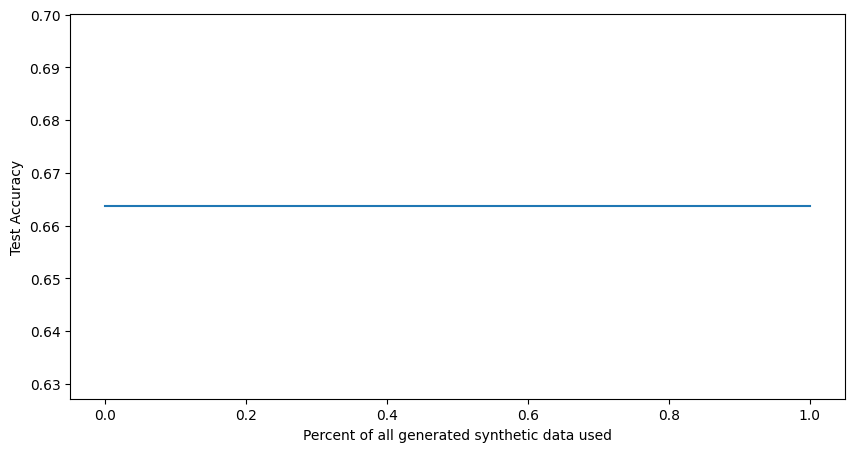

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.plot(percents, test_acc)
plt.xlabel("Percent of all generated synthetic data used")
plt.ylabel("Test Accuracy")

In [ ]:
%load_ext tensorboard
%tensorboard --logdir test_logs/

In [ ]:
X_train_valid = np.load("project/X_train_valid.npy")
X_train_valid.shape

(2115, 22, 1000)